# Evaluation of Classifiers

## Class Imbalance and Accuracy

You may have noticed that the fraud classification dataset is a highly class-imbalanced dataset.

In [95]:
import pandas as pd

fraud = pd.read_csv('course_data/Machine Learning Algorithms/fraud_data.csv')

fraud.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,1.176563,0.323798,0.536927,1.047002,-0.368652,-0.728586,0.084678,-0.069246,-0.266389,0.155315,...,-0.109627,-0.341365,0.057845,0.499180,0.415211,-0.581949,0.015472,0.018065,4.67,0
1,0.681109,-3.934776,-3.801827,-1.147468,-0.735540,-0.501097,1.038865,-0.626979,-2.274423,1.527782,...,0.652202,0.272684,-0.982151,0.165900,0.360251,0.195321,-0.256273,0.056501,912.00,0
2,1.140729,0.453484,0.247010,2.383132,0.343287,0.432804,0.093380,0.173310,-0.808999,0.775436,...,-0.003802,0.058556,-0.121177,-0.304215,0.645893,0.122600,-0.012115,-0.005945,1.00,0
3,-1.107073,-3.298902,-0.184092,-1.795744,2.137564,-1.684992,-2.015606,-0.007181,-0.165760,0.869659,...,0.130648,0.329445,0.927656,-0.049560,-1.892866,-0.575431,0.266573,0.414184,62.10,0
4,-0.314818,0.866839,-0.124577,-0.627638,2.651762,3.428128,0.194637,0.670674,-0.442658,0.133499,...,-0.312774,-0.799494,-0.064488,0.953062,-0.429550,0.158225,0.076943,-0.015051,2.67,0


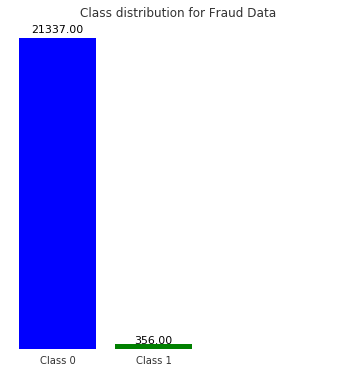

In [96]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from itertools import cycle

# create a generator that loops through the colours
# blue, green and red
cycle_cmap = cycle(['b', 'g', 'r'])

def plot_imbalance(classes):
    """
    Plot an annotated bar graph of the class distribution for a Series
    of distinctly-labelled classes.
    
    :param classes: Pandas series of class labels for a dataset.
    """
    val_counts = classes.value_counts()
    counts = val_counts.values
    labels = val_counts.index.values
    
    plt.figure(figsize=(6, 6))
    
    # plot the bars
    bars = plt.bar(np.arange(len(val_counts)), counts,
                   color=[next(cycle_cmap) for i in range(len(val_counts))])
    
    # add text to the bars
    for bar in bars:
        height = bar.get_height()
        plt.gca()\
           .text(bar.get_x() + bar.get_width()/2, height*1.02,
                 '{0:.{1}f}'.format(height, 2), 
                 ha='center', color='black', fontsize=11)
            
     # remove all the ticks (both axes), and tick labels on the Y axis
    plt.tick_params(top=False, bottom=False, left=False,
                    right=False, labelleft=False, labelbottom=True)

    # remove the frame of the chart
    for spine in plt.gca().spines.values():
        spine.set_visible(False)
        
    # label the chart
    plt.xticks([0,1,2,3], [f'Class {i}' for i in labels], alpha=0.8);
    plt.title('Class distribution for Fraud Data', alpha=0.8)
    
plot_imbalance(fraud['Class'])

The class distribution actually has real implications for classification on the dataset. Lets look at classification using a default-valued support vector classifier:

In [113]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

X = fraud.iloc[:, :-1]
y = fraud.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# set probability=True in the SVC initialisation to enable probability
# estimates for predictions
svc = SVC(probability=True).fit(X_train, y_train)

In [114]:
acc = sum(svc.predict(X_test) == y_test) / len (y_test)
print(f'Test accuracy: {acc * 100:.2f}%')

Test accuracy: 99.17%


Well, fantastic! We have a classifier that is over 99% accurate. Given that this is a highly class-imbalanced problem, though, a sensible baseline comparison for our classifier would be with a naive strategy that simply *always classifies observations to the majority class*.

Sk-learn has precisely what we need here, in the form of the `DummyClassifier` class. It has a number of naive baseline strategies that can be selected with the `strategy` argument:

* `stratified`: generates predictions by respecting the training
  set's class distribution.
* `most_frequent`: always predicts the most frequent label in the
  training set.
* `prior`: always predicts the class that maximizes the class prior
  (like `most_frequent`) and ``predict_proba`` returns the class prior.
* `uniform`: generates predictions uniformly at random.
* `constant`: always predicts a constant label that is provided by
  the user. This is useful for metrics that evaluate a non-majority
  class
  
For our highly class-imbalanced problem, `most_frequent` is the relevant strategy, as mentioned.

In [115]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import recall_score, accuracy_score

dummy = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)

pred = dummy.predict(X_test)

acc = accuracy_score(y_true=y_test, y_pred=pred)
print(f'Test accuracy: {acc * 100:.2f}%')

Test accuracy: 98.47%


A naive strategy that classifies all observations to the majority class achieves a test accuracy of 98.47%. This contextualises our SVM's 99% accuracy in a very important way. Accuracy is simply not a nuanced enough metric for assessing the quality of classification in a class-imbalanced content. Lets explore some new ones.

## Precision and Recall
Precision and recall is a measure of classifier performance that provides important information in the context of class imbalance. In the context of a binary classification problem with labels $0, 1$, the measures identify the following:

1. Precision: the percentage of observations labelled as 1 that had true class labels of 1. i.e. The percentage of observations classified as positive that were truly positive.
2. Recall: the percentage of observations with a true class label of 1 that were correctly identified as 1s. i.e. The percentage of truly positive observations that were correctly classified as positive.

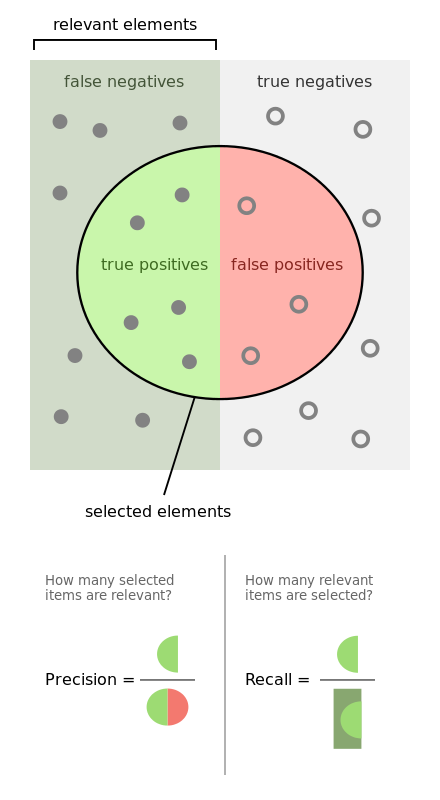
By Walber - Own work, CC BY-SA 4.0, [https://commons.wikimedia.org/w/index.php?curid=36926283](https://commons.wikimedia.org/w/index.php?curid=36926283)

In practice, it's very useful to be able to visualise the recall and precision for probabilistic classifiers. SVMs don't output probabilitic predictions by default, however these can be [derived](https://stackoverflow.com/questions/15111408/how-does-sklearn-svm-svcs-function-predict-proba-work-internally). The precision and recall values at different probability thresholds can then be plotted.

Order of classes: [0 1]


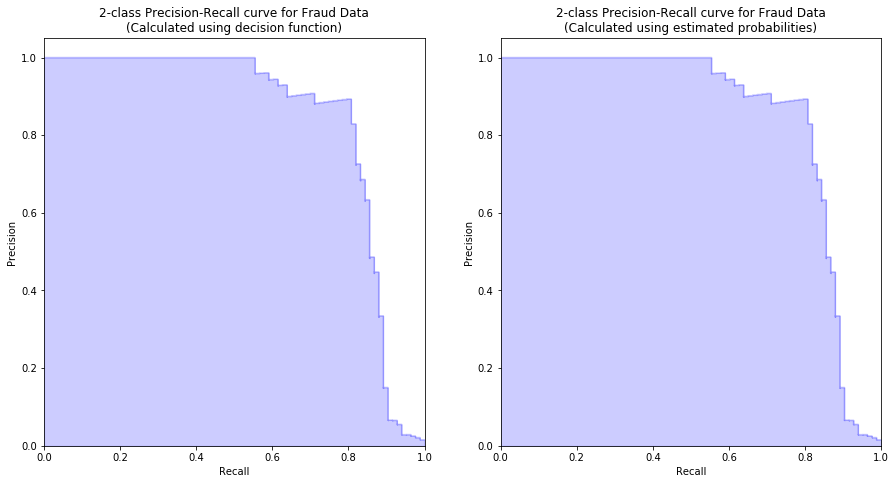

In [154]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

def recall_precision_subplot(recall, precision, ax, opt_title=None):
    """
    Plot recall and precision curve on a given axis.
    
    :param recall: recall values at each evaluation point
    :param precision: precision values at each evaluation point
    :param ax: Matplotlib axis object
    :param opt_title: optional additional text for plot title
    """
    ax.step(recall, precision, color='b', alpha=0.2,
             where='post')
    ax.fill_between(recall, precision, step='post', alpha=0.2,
                     color='b')
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_ylim([0.0, 1.05])
    ax.set_xlim([0.0, 1.0]) 
    title = '2-class Precision-Recall curve for Fraud Data'
    if opt_title:
        title += '\n' + opt_title
    ax.set_title(title)
    
# create the figure and axes for a two-element subplot
f, axs = plt.subplots(1,2,figsize=(15,7.5))

# use the classifier's decision function to get precision and recall
y_score = svc.decision_function(X_test)
precision, recall, _ = precision_recall_curve(y_test, y_score)
recall_precision_subplot(recall, precision, axs[0],
                        opt_title='(Calculated using decision function)')

# obtain predicted probs for positive class
print(f'Order of classes: {svc.classes_}')
y_score = svc.predict_proba(X_test)[:, svc.classes_ == 1]
precision, recall, _ = precision_recall_curve(y_test, y_score)
recall_precision_subplot(recall, precision, axs[1],
                        opt_title='(Calculated using estimated probabilities)')

As you can see, the precision recall curves generated using the estimated probabilites are the decision function for the SVM are identical. The probabilites involve extra computation at train time, but are perhaps slightly more intuitive in understanding how the precision and recall graph is constructed. Ideally, we want to maximize the region under the graph.

Lets contrast the precision and recall graph for the dummy classifier.

Probabilities of positive class:
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]...


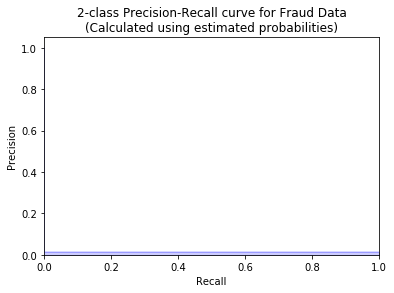

In [162]:
y_score = dummy.predict_proba(X_test)[:, dummy.classes_ == 1]
print(f'Probabilities of positive class:\n{y_score[:5]}...')
precision, recall, _ = precision_recall_curve(y_test, y_score)
recall_precision_subplot(recall, precision, plt.gca(),
                        opt_title='(Calculated using estimated probabilities)')

The curve is trivially terrible! Even though its accuracy is 98%, the dummy classifier can either retrieve all the positive examples at a 0% probability threshold (i.e. 100% recall, ~0% precision), or none of them at any other threshold (i.e. 0% recall, undefined precision).

## ROC Curves
Another informative graphical devise is the Receiver Operator Characteristic (ROC) curve, which is generated by plotting the true positive rate (TPR, which is the same as recall), also known as $sensitivity$ and the false positive rate (FPR), which is calculated as $1 - specificity$.

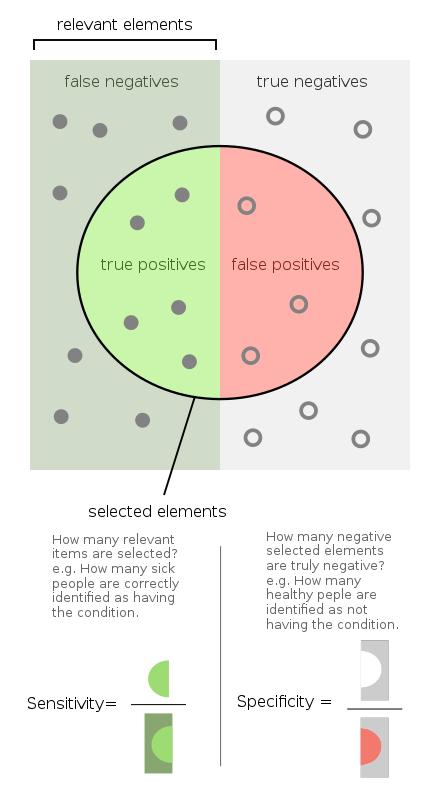
By FeanDoe - Modified version from Walber's Precision and Recall [https://commons.wikimedia.org/wiki/File:Precisionrecall.svg, CC BY-SA 4.0](https://commons.wikimedia.org/w/index.php?curid=65826093)

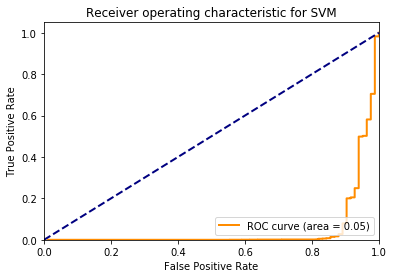

In [170]:
from sklearn.metrics import roc_curve, auc

# using our SVM again
y_score = svc.decision_function(X_test)

tpr, fpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for SVM')
plt.legend(loc="lower right")
plt.show()

This immediately shows us that we can only obtain a good recall value at the cost of a high false positive rate with our current classifier. The area under the curve (often referred to as simply the AUC) is equal to the probability that a classifier will rank a randomly chosen positive instance higher than a randomly chosen negative one (assuming 'positive' ranks higher than 'negative'). A score of $0.05$ indicates a very poor overall classifier!

## Confusion Matrices

It can also be very useful to visualise the specific errors that the classifier is making. A *confusion matrix* is exactly what we need in this scenario. It gives an explicit break-down of the errors and successes made by the classifier with respect to its predicted classes relative to the ground truth.

In [188]:
from itertools import product

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    :param cm: Numpy array confusion matrix 
    :param classes: Numpy array of the set of classes classified
    :param title: plot title
    :param cmap: Matplotlib colour map object
    """
    if normalize:
        # normalize by number of observations for class per row
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    # plot the confusion matrix as a heat map on a grid
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = ('.2f', '%') if normalize else ('d', '')
    thresh = cm.max() / 2.
    # for each cell in the confusion matrix annotate the
    # number observations. Text colour depends on cell colour
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f'{cm[i, j]:{fmt[0]}}{fmt[1]}',
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[5341    0]
 [  45   38]]
Normalized confusion matrix
[[1.   0.  ]
 [0.54 0.46]]


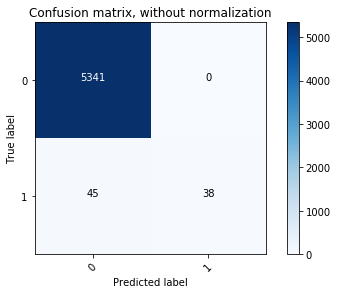

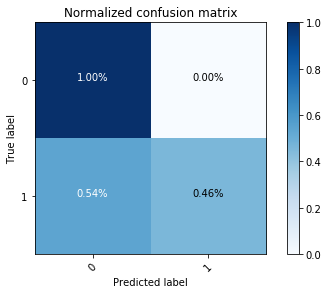

In [189]:
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
y_pred = svc.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=svc.classes_,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=svc.classes_, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

## Boosting

We'll use a simple constructed example to develop an intuition behind the boosting algorithm.

Lets jump right into the data:

In [257]:
import pandas as pd

toy_data = pd.read_csv('course_data/Evaluating Classifiers/toy_data.csv')
toy_data.set_index('PersonID', inplace=True)

In [258]:
toy_data

,Age,LikesGardening,PlaysVideoGames,LikesHats
PersonID,,,,
1,13,False,True,True
2,14,False,True,False
3,15,False,True,False
4,25,True,True,True
5,35,False,True,True
6,49,True,False,False
7,68,True,True,True
8,71,True,False,False
9,73,True,False,True


We're going to predict the `age` of individuals given the features `LikesGardening`, `PlaysVideoGames` and `LikesHats`. This is a simple toy dataset, and the following intuitive observations can be made on the features:
1. People who like gardening are probably older
2. People who like videogames are probably younger
3. Liking hats is probably not reliably correlated with age

**Exercise:** Do some quick analysis of the data (not modelling) to check the reasonableness of the above assumptions.

Lets get right into modelling. We'll divide our features and targets, then fit a relatively shallow tree— constrained to split the observations into nodes that have no fewer than 3 observations.

In [203]:
# split our target age from the other features
X = toy_data.iloc[:, 1:]
y = toy_data.iloc[:, 0]

In [210]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(min_samples_leaf=3).fit(X, y)

In [219]:
%matplotlib inline
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
import graphviz

def plot_tree(tree, features):
    """
    Plot an sklearn decision tree in a notebook environment
    
    :param tree: sklearn decision tree object
    :param features: feature names
    """
    dot_data = StringIO()
    export_graphviz(tree, out_file=dot_data,  
                    filled=True, rounded=True,
                    special_characters=True,
                    feature_names=features)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    return Image(graph.create_png())

Fontconfig warning: "/etc/fonts/conf.d/65-droid-sans-fonts.conf", line 61: Having multiple values in <test> isn't supported and may not work as expected
Fontconfig warning: "/etc/fonts/conf.d/65-droid-sans-fonts.conf", line 96: Having multiple values in <test> isn't supported and may not work as expected



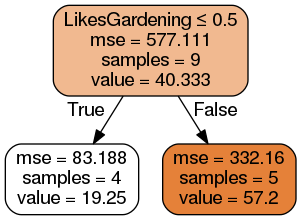

In [220]:
plot_tree(tree, X.columns)

We'll now fit a less constrained regression tree, that can split the observations into nodes with as few as 2 observations.

Fontconfig warning: "/etc/fonts/conf.d/65-droid-sans-fonts.conf", line 61: Having multiple values in <test> isn't supported and may not work as expected
Fontconfig warning: "/etc/fonts/conf.d/65-droid-sans-fonts.conf", line 96: Having multiple values in <test> isn't supported and may not work as expected



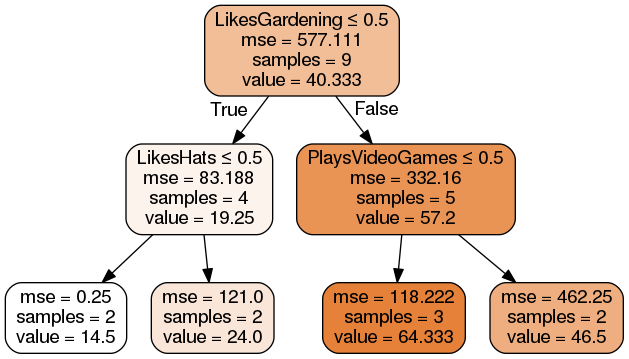

In [222]:
tree = DecisionTreeRegressor(min_samples_leaf=2).fit(X, y)

plot_tree(tree, X.columns)

A tree that we allow to split more finely **clearly overfits to the noise in the data**: in the left-hand branch it has divided the node by whether or not the person likes hats, a feature unlikely to be correlated with age.

Lets try a different approach, where we take the first, shallow tree that we fitted, and fit another shallow tree **to its residuals**. The residuls are generally given according to:
$$
e_i = y_i - \hat{y}_i,
$$
where $e_i$ is the *residual* for th *i*th person, $y_i$ is true age of the *i*th person and $\hat{y}_i$ is their predicted age.

In [247]:
#recreate the first tree
tree = DecisionTreeRegressor(min_samples_leaf=3).fit(X, y)
tree_pred = tree.predict(X)
residuals = y - tree_pred
residuals

PersonID
1    -6.25
2    -5.25
3    -4.25
4   -32.20
5    15.75
6    -8.20
7    10.80
8    13.80
9    15.80
Name: Age, dtype: float64

Fontconfig warning: "/etc/fonts/conf.d/65-droid-sans-fonts.conf", line 61: Having multiple values in <test> isn't supported and may not work as expected
Fontconfig warning: "/etc/fonts/conf.d/65-droid-sans-fonts.conf", line 96: Having multiple values in <test> isn't supported and may not work as expected



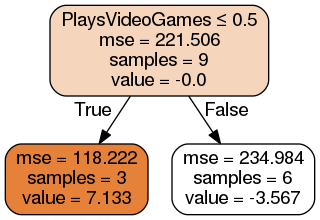

In [260]:
# now fit a new tree to the residuals of the first tree
tree = DecisionTreeRegressor(min_samples_leaf=3).fit(X, residuals)

plot_tree(tree, X.columns)

An immediate standout is that this tree, fitted on the residuals of the shallow tree, does not split on the noise in the data. An intuitive explanation for this is the fact that in the overfit tree, after the first split, subsequent splits are made only considering the data within each node— a small subset of the total dataset. The model may by chance consider a subset where liking hats looks well-correlated with age.

However, when shallow trees (in the case of a small dataset like this, with a single split), can consider the entire dataset at each decision point, and remain aware of the overarching relationships in the data.

We haven't addressed the question of why we'd fit the tree to the residuals of the first tree yet. Consider the following algorithm:

1. Fit a tree to the data: $F_1(x) = y$
2. Fit a tree to the residuals of the first tree $e_1(x) = y - F_1(x)$
3. Add the predictions of both trees for a new model: $F_2(x) = F_1(x) + h_1(x)$

If we were to simply add the residuals of a model to its predictions, we would recover the true target value: 
$$
\hat{y}_i + e_i = \hat{y}_i + y_i - \hat{y}_i =y_i
$$

Therefore the model fitted on the residuals is accurate, adding both models *moves the model closer to the desired prediction*. Lets look at this effect given our fitted models:


In [261]:
pred_data = toy_data.loc[:, ['Age']]
pred_data['Tree 1 Prediction'] = tree_pred
pred_data['Tree 1 Residual'] = residuals
pred_data['Tree 2 Prediction'] = tree.predict(X)
pred_data['Combined Prediction']  = pred_data.apply(lambda row: row['Tree 1 Prediction'] + 
                                                    row['Tree 2 Prediction'], axis=1)
pred_data['Final Residual'] = pred_data['Age'] - pred_data['Combined Prediction']
pred_data

,Age,Tree 1 Prediction,Tree 1 Residual,Tree 2 Prediction,Combined Prediction,Final Residual
PersonID,,,,,,
1,13,19.25,-6.25,-3.566667,15.683333,-2.683333
2,14,19.25,-5.25,-3.566667,15.683333,-1.683333
3,15,19.25,-4.25,-3.566667,15.683333,-0.683333
4,25,57.20,-32.20,-3.566667,53.633333,-28.633333
5,35,19.25,15.75,-3.566667,15.683333,19.316667
6,49,57.20,-8.20,7.133333,64.333333,-15.333333
7,68,57.20,10.80,-3.566667,53.633333,14.366667
8,71,57.20,13.80,7.133333,64.333333,6.666667
9,73,57.20,15.80,7.133333,64.333333,8.666667


In [262]:
tree1_sse = sum(pred_data['Tree 1 Residual'] **2)
combined_sse = sum(pred_data['Final Residual'] **2)
print(f'Tree 1 sum of squared errors: {tree1_sse:.2f}')
print(f'Combined sum of squared errors: {combined_sse:.2f}')

Tree 1 sum of squared errors: 1993.55
Combined sum of squared errors: 1764.57


Boosting follows from the principles outlined above, repeated recursively:

1. Grow a number of trees $B$ recursively.
2. Grow each tree on the residuals of the previous tree, with some modifier $\lambda$ that multiplies the residuals and controls the rate at which the boosting model learns.
3. A number of splits $d$ or maximum depth for each tree. Often, as in our example $d=1$ works well, and each tree is just a single split.

If you want to get into more depth on the boosting algorithm, read the rest of this [blog post](http://blog.kaggle.com/2017/01/23/a-kaggle-master-explains-gradient-boosting/), which inspired our initial motivation for the boosting algorithm.

**Exercise: Boosting and Model Evaluation.** Using the `XGBoost` package in Python, apply boosting to the fraud data, and tune your models for the best performance using the AUC metric. Visualise final model performance using Precision Recall, ROC and a confusion matrix.